<a href="https://colab.research.google.com/github/heokyeol/audrey21/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Push-up Manager App**


We created an app that can assist users with push-ups using Fastai Vision's image classification. The model outputs the number of exercising, the operating time of each set and the total exercise time through the user's push-up video. The model is trained to distinguish the up-down position of the push-up. The input video is dataized by dividing all frames into images. Each frame is classified as 'Up' or 'Down' through the model and each prediction and probability is stored in the list. By using this list, the model determines the final output. The number of times is counted by the distribution plot and the time by the number of frames.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
from fastai.vision import *
from matplotlib import pyplot as plt
import numpy as np

## Frame extraction

In [69]:
vname = 'Video1.mp4'
v_path = ('/content/drive/MyDrive/dna/push-up dataset/video/%s'%vname)
f_path=('/content/drive/MyDrive/dna/push-up dataset/frames/%s'%vname)
path = Path(f_path)
path.mkdir(exist_ok=True)

# Specify the video to be analyzed in vname.
# Specify the path of video and folder. 
# v_path : Path of input video
# f_paty : Path where the imaged will be stored

In [70]:
vidcap = cv2.VideoCapture(v_path)
count = 0
while(vidcap.isOpened()):
    ret, image = vidcap.read()
    if np.any(image) == None : break
    cv2.imwrite('%s/frame%d.jpg'%(path,count), image)
    count += 1
vidcap.release()

# extract all the frames from the video

## Class specification

In [71]:
path = Path('drive/MyDrive/dna/push-up dataset/updown')

# Path of dataset
# Dataset is made up with about 200 "up" and "down" position images.

In [73]:
classes = ['up','down']

In [74]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

up


down


In [75]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Training the model

In [80]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.295218,1.281568,0.521739,00:02
1,1.346728,0.338827,0.217391,00:02
2,1.027242,0.359760,0.130435,00:02
3,0.802667,0.391781,0.130435,00:02


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find(start_lr = 1e-04)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


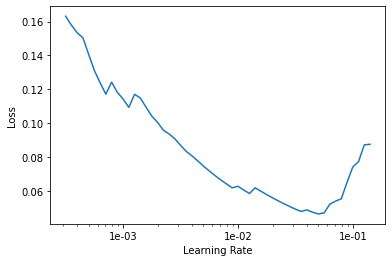

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,slice(1e-02,1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,0.193637,0.615130,0.130435,00:02
1,0.165208,2.507862,0.217391,00:02
2,0.147674,2.738310,0.130435,00:02
3,0.294828,1.760022,0.130435,00:02


In [ ]:
learn.save('well_done!_1')

## learning rate determination and analysis

In [81]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.load('well_done!_2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

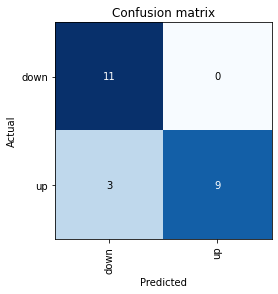

In [ ]:
interp.plot_confusion_matrix()

##Apply Image

In [82]:
path=Path(f_path)
path

PosixPath('/content/drive/MyDrive/dna/push-up dataset/frames/Video1.mp4')

In [83]:
len(path.ls())

632

In [84]:
lis=[]
for i in range(len(path.ls())):
  img = open_image(Path('/content/drive/MyDrive/dna/push-up dataset/frames/%s/frame%d.jpg'%(vname,i)))
  pre = learn.predict(img)
  lis.append(pre)
# Make all prediction of each frame into a list

[(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.9579e-07])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 5.1875e-11])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 1.3425e-11])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 1.0583e-13])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 3.4720e-14])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 4.7877e-12])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 1.2614e-11])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 1.0543e-06])),
 (Category tensor(0), tensor(0), tensor([9.9998e-01, 1.7587e-05])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 1.2585e-07])),
 (Category tensor(0), tensor(0), tensor([1.0000e+00, 4.4318e-06])),
 (Category tensor(1), tensor(1), tensor([0.3698, 0.6302])),
 (Category tensor(1), tensor(1), tensor([0.0565, 0.9435])),
 (Category tensor(1), tensor(1), tensor([1.7466e-04, 9.9983e-01])),
 (Category tensor(1), tensor(1), tensor([0.1716, 0.8284])),
 (Ca

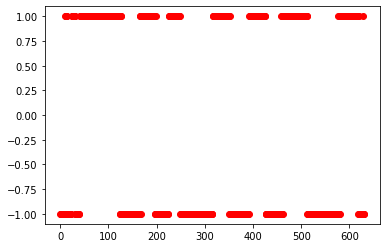

In [85]:
x = range(len(lis))
y = [((-1)**(int(lis[i][0])+1)) for i in range(len(lis))]

plt.plot(x,y,'or')

# Graph with prediction

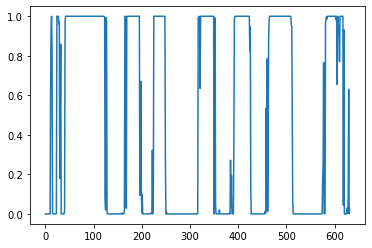

In [86]:
x = range(len(lis))
y = [float(lis[i][2][1]) for i in range(len(lis))]
plt.plot(x,y)

# Graph with probability

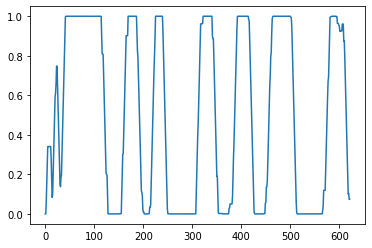

In [87]:
x = range(len(lis)-10)
y = [float(lis[i][2][1]) for i in range(len(lis))]

y = [sum(y[i:i+10])/10 for i in range(len(lis)-10)]
plt.plot(x,y)

# Refined Graph with arithmetical average method.
# It eliminates misidentified frames.

In [88]:
cot=0
a=[]
for i in range(len(y)):
  if y[i]<0.1:
    a.append(1)
  else : a.append(0)

for i in range(len(a)-10):
  if a[i+1:i+10].count(1)==9 and a[i]==0:
    cot +=1
    print(cot)

# Count the number of exercising.

1
2
3
4
5
6


In [89]:
ulis=[]
dlis=[]
for i in range(len(a)-10):
  if a[i+5:i+10].count(1)==5 and a[i:i+5].count(1)==0 :
    dlis.append(i)
  if a[i+5:i+10].count(1)==0 and a[i:i+5].count(1)==5 :
    ulis.append(i)
dlis, ulis

# Specify the frames which goes down(dlis) and up(ulis).

([122, 193, 244, 348, 421, 507], [151, 211, 304, 378, 446, 563])

In [100]:
arr=[]
t=0
for i in range(cot):
  rate = (ulis[i]-dlis[i])/30
  arr.append(rate)
  print('%d st rating : %0.2f sec'%(i+1,rate))
  t += rate
m_arr = np.mean(arr)
s_arr = np.std(arr)
print('\nExercise time : %0.2f'%t)
print('Average rate : %0.2f'%m_arr)
if s_arr > 0.1 : print('\nThe rate is irregular.')
if m_arr < 1.5 : print('The average rate is short, %0.1f sec. Try to get closer to two seconds.'%m_arr)
elif m_arr > 2.5 : print('The average rate is long, %0.1f sec. Try to get closer to two seconds.'%m_arr)
else : print('\nWell done!')

# Final Results.
# "s_arr" is standard of rate and "m_arr" is mean of rate.

1 st rating : 0.97 sec
2 st rating : 0.60 sec
3 st rating : 2.00 sec
4 st rating : 1.00 sec
5 st rating : 0.83 sec
6 st rating : 1.87 sec

Exercise time : 7.27
Average rate : 1.21

The rate is irregular.
The average rate is short, 1.2 sec. Try to get closer to two seconds.
